<a href="https://colab.research.google.com/github/argent0/tensorflow-course/blob/master/ACGAN_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AcGAN  for MNIST Data

In [0]:
!pip install -q tensorflow==2.0.0-alpha0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd

import matplotlib.pyplot as plt

from keras.datasets import mnist

import numpy as np

from collections import defaultdict

print(keras.backend.backend())

print(tf.__version__)
print(keras.__version__)

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

tf.test.gpu_device_name()

tensorflow
1.13.1
2.2.4-tf


'/device:GPU:0'

In [0]:
# Load the Mnist dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


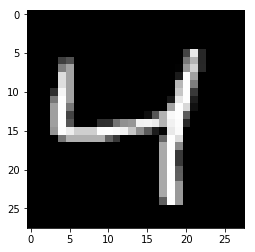

In [0]:
# Display one digit
plt.imshow(x_train[2].reshape((28,28)), cmap=plt.cm.gray)


In [0]:
# normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_test = x_test - 0.5
x_train = x_train - 0.5
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)
num_train, num_test = x_train.shape[0], x_test.shape[0]

(60000, 28, 28, 1)


## The model

In [0]:
np.random.seed(1337)
num_classes = 10

In [0]:
# build a generator model
def build_generator(latent_size):
  # map (z, L) to an image space (...,28, 28, 1)
  # where z is the "noise" and L is label
  cnn = keras.Sequential()
  
  # from the "noise" a 384 blocks of 3 by 3 will be generated
  cnn.add(keras.layers.Dense(units= 3 * 3 * 384, input_dim=latent_size, activation='relu'))
  cnn.add(keras.layers.Reshape((3,3,384)))
  
  # the 3x3 blocks are upsampled to 7x7
  # 192 such transformations are generated
  cnn.add(keras.layers.Conv2DTranspose(filters=192, kernel_size=5,
                                      strides=1, padding='valid'
                                      , kernel_initializer='glorot_normal'))
  
  cnn.add(keras.layers.BatchNormalization())
  
  #upsample to 14x14
  cnn.add(keras.layers.Conv2DTranspose(filters=96, kernel_size=5,
                                      strides=2, padding='same',
                                      activation='relu',
                                      kernel_initializer='glorot_normal'))
  cnn.add(keras.layers.BatchNormalization())
  
  # upsample to (28, 28, ...)
  cnn.add(keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same',
                          activation='tanh',
                          kernel_initializer='glorot_normal'))

  # this is the z space commonly referred to in GAN papers
  latent = keras.layers.Input(shape=(latent_size, ))
  
  #the label or auxiliary class to guide the image generation
  image_class = keras.layers.Input(shape=(1,), dtype='int32')
  
  # this tensor turns the class into a dense vector (an embedding)
  cls = keras.layers.Embedding(input_dim=num_classes, #the vocabulary size
                              output_dim= latent_size,
                              embeddings_initializer='glorot_normal')(image_class)
  
  #hadamard produvt between z-space and a class conditional embedding
  h = keras.layers.multiply([latent, cls])
  
  fake_image = cnn(h)
  
  return keras.Model(inputs=[latent, image_class], outputs=fake_image)
  

In [0]:
# build the discriminator

def build_discriminator():
  # relatively standard conv net
  cnn = keras.Sequential()
  
  cnn.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                             padding='same', strides=2
                             ,input_shape=(28, 28, 1)))
  
  cnn.add(keras.layers.LeakyReLU(alpha=0.2))
  # allows a gradient when the unit is not active
  # f(x) = alpha * x for x < 0, f(x) = x for x >= 0
  
  cnn.add(keras.layers.Dropout(rate=0.3)) #assing a velue of 0 to 30% of the units, prevents overfitting
  
  
  cnn.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                             padding='same', strides=1))
  cnn.add(keras.layers.LeakyReLU(alpha=0.2))  
  cnn.add(keras.layers.Dropout(rate=0.3))
  
  cnn.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                             padding='same', strides=2))
  cnn.add(keras.layers.LeakyReLU(alpha=0.2))  
  cnn.add(keras.layers.Dropout(rate=0.3))
  
  cnn.add(keras.layers.Conv2D(filters=256, kernel_size=3,
                             padding='same', strides=1))
  cnn.add(keras.layers.LeakyReLU(alpha=0.2))  
  cnn.add(keras.layers.Dropout(rate=0.3))
  
  cnn.add(keras.layers.Flatten())
  
  
  image = keras.layers.Input(shape=(28, 28, 1))
  
  features = cnn(image)
  
  # first output (name=generation) is whether or not the discriminator
  # thinks the image that is being shown is fake, and the second output
  # (name=auxiliary) is the class that the discriminator thinks the image
  # belongs to.
  fake = keras.layers.Dense(1, activation='sigmoid', name='generation')(features)
  aux = keras.layers.Dense(num_classes, activation='softmax', name='auxiliary')(features)
  
  return keras.Model(inputs=image, outputs=[fake, aux])
                           

In [0]:
# training the model
# some parameters

epochs = 100
batch_size = 100
latent_size = 100

adam_lr = 0.0002
adam_beta_1 = 0.5


In [0]:
# Discriminator model
print('Discriminator model:')
discriminator = build_discriminator()
discriminator.compile(
  optimizer=keras.optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
  loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
discriminator.summary()

Discriminator model:
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 12544)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       sequential[1][0]                 
__________________________________________________________________________________________________


In [0]:
# generator
generator = build_generator(latent_size)

In [0]:
# Combined model

latent = keras.layers.Input(shape=(latent_size,))
image_class = keras.layers.Input(shape=(1,), dtype='int32')

# the fake image "tensor"
fake = generator([latent, image_class])

# only train the generation *for the combined model*
discriminator.trainable = False
fake, aux = discriminator(fake) #now fake is wether the disc. says it's fake
combined = keras.Model([latent, image_class], [fake, aux])

combined.compile(
  optimizer=keras.optimizers.Adam(lr=adam_lr, beta_1=adam_beta_1),
  loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    2657897     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model (Model)                   [(None, 1), (None, 1 525835      model_1[1][0]                    
Total para

## Training

In [0]:
train_history = defaultdict(list)
test_history = defaultdict(list)

for epoch in range(1, epochs + 1):
  print('Epoch {}/{}'.format(epoch, epochs))
  
  num_batches = int(np.ceil(num_train / float(batch_size)))
  
  epoch_gen_loss = []
  epoch_disc_loss = []
  
  for index in range(num_batches):
    image_batch = x_train[index * batch_size : (index + 1) * batch_size]
    label_batch = y_train[index * batch_size : (index + 1) * batch_size]
    
    # generate some noise
    noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))
    
    # sample som lebels from p_c
    sampled_labels = np.random.randint(0, num_classes, len(image_batch))
    
    # batch of fake images
    
    generated_images = generator.predict(
      [noise, sampled_labels.reshape((-1,1))], verbose=0)
    
    #plt.imshow(generated_images[0].reshape((28,28)), cmap = plt.cm.gray)
    
    # the input for the discriminator
    x = np.concatenate((image_batch, generated_images))
    
    # TRICK: use one-sided soft/fake labels
    soft_zero, soft_one = 0, 0.95
    y = np.array(
      [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
    aux_y = np.concatenate((label_batch, sampled_labels), axis=0)
    
    # the discrimiator does NOT have to maximize the classification accuracy
    # of the auxiliaty classifier on generated images. Just discrimination.
    
    # sample weight of 2 to the real images
    disc_sample_weight = [np.ones(2 * len(image_batch)),
                         np.concatenate((np.ones(len(image_batch)) * 2,
                                        np.zeros(len(image_batch))))]
    
    # train the discriminator a little
    epoch_disc_loss.append(discriminator.train_on_batch(
      x, [y, aux_y], sample_weight=disc_sample_weight))
    
    
    # make new noise. 3 * batch_size so we have the generator optimize over an
    # identical number of images to the discriminator
    noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
    sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))
    
    # we want all the fake/non-fake labels to say non-fake
    trick = np.ones(2 * len(image_batch)) * soft_one
    
    epoch_gen_loss.append(combined.train_on_batch(
      [noise, sampled_labels.reshape((-1, 1))],
      [trick, sampled_labels]))
  
    # end batch loop
  
  # evaluate test loss
  print('Testing for epoch {}:'.format(epoch))
  
  # new batch of noise
  noise = np.random.uniform(-1, 1, (num_test, latent_size))
  
  # sample some labels
  sampled_labels = np.random.randint(0, num_classes, num_test)
  generated_images = generator.predict(
    [noise, sampled_labels.reshape((-1, 1))], verbose=False)
  
  x = np.concatenate((x_test, generated_images))
  y = np.array([1] * num_test + [0] * num_test)
  aux_y = np.concatenate((y_test, sampled_labels), axis=0)
  
  discriminator_test_loss = discriminator.evaluate(
    x, [y, aux_y], verbose=False)
  
  discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)
  
  
  # generator train/test loss
  
  noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
  sampled_labels = np.random.randint(0, num_classes, 2 * num_test)
  
  trick = np.ones(2 * num_test)
  
  generator_test_loss = combined.evaluate(
    [noise, sampled_labels.reshape((-1, 1))],
    [trick, sampled_labels], verbose=False)
  
  generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
  
  # generate an epoch report on performance
  train_history['generator'].append(generator_train_loss)
  train_history['discriminator'].append(discriminator_train_loss)

  test_history['generator'].append(generator_test_loss)
  test_history['discriminator'].append(discriminator_test_loss)

  print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
      'component', *discriminator.metrics_names))
  print('-' * 65)
  
  ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
  print(ROW_FMT.format('generator (train)',
                       *train_history['generator'][-1]))
  print(ROW_FMT.format('generator (test)',
                       *test_history['generator'][-1]))
  print(ROW_FMT.format('discriminator (train)',
                       *train_history['discriminator'][-1]))
  print(ROW_FMT.format('discriminator (test)',
  *test_history['discriminator'][-1]))
    
  

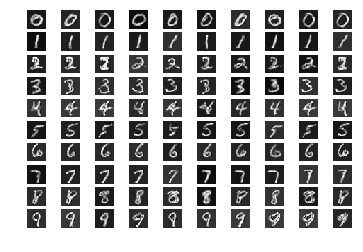

In [0]:
# generate digits to display
num_rows = 10
noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                (num_classes, 1))
  
sampled_labels = np.array([
    [i] * num_rows for i in range(num_classes)
]).reshape(-1, 1)
  
# get a batch to display
generated_images = generator.predict(
  [noise, sampled_labels], verbose=0)
  
fig, axes = plt.subplots(num_rows, num_classes)
img_idx = 0
for row in range(num_rows):
  for col in range(num_classes):
    axes[row, col].imshow(generated_images[img_idx].reshape((28, 28)), cmap=plt.cm.gray)
    axes[row, col].axis('off')
    img_idx = img_idx + 1